<a href="https://colab.research.google.com/github/Alphatrion-star/github-pages/blob/main/Covid_19_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID-19 Analysis Project (EDA + Plotly + Prophet)

In [ ]:
# Step 1: Upload dataset
from google.colab import files
import pandas as pd
import numpy as np
import plotly.express as px
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
uploaded = files.upload()
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)

Saving covid_19_clean_complete.csv to covid_19_clean_complete.csv


In [ ]:
df.head()

,Province_State,Country_Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO_Region
0,NaN,Afghanistan,33.93911,67.709953,2020-01-22,0,0,0,0,Eastern Mediterranean
1,NaN,Albania,41.15330,20.168300,2020-01-22,0,0,0,0,Europe
2,NaN,Algeria,28.03390,1.659600,2020-01-22,0,0,0,0,Africa
3,NaN,Andorra,42.50630,1.521800,2020-01-22,0,0,0,0,Europe
4,NaN,Angola,-11.20270,17.873900,2020-01-22,0,0,0,0,Africa


In [ ]:
# Step 2: Clean dataset
df.columns = [c.strip().replace("/", "_").replace(" ", "_") for c in df.columns]
df["Date"] = pd.to_datetime(df["Date"])

for col in ["Confirmed","Deaths","Recovered","Active"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col],errors="coerce")
print("Data Loaded Successfully!")

Data Loaded Successfully!


In [ ]:
countries=df.groupby('Country_Region')[['Confirmed','Deaths','Recovered','Active']].sum() #grouping by countries and aggregating the covid cases columns
countries

,Confirmed,Deaths,Recovered,Active
Country_Region,,,,
Afghanistan,1936390,49098,798240,1089052
Albania,196702,5708,118877,72117
Algeria,1179755,77972,755897,345886
Andorra,94404,5423,69074,19907
Angola,22662,1078,6573,15011
...,...,...,...,...
West Bank and Gaza,233461,1370,61124,170967
Western Sahara,901,63,648,190
Yemen,67180,17707,23779,25694


In [ ]:
# PART 1: EDA
print("\nDataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isna().sum())
print("\nSummary Statistics:\n", df.describe())


Dataset Shape: (49068, 10)

Columns: ['Province_State', 'Country_Region', 'Lat', 'Long', 'Date', 'Confirmed', 'Deaths', 'Recovered', 'Active', 'WHO_Region']

Data Types:
 Province_State            object
Country_Region            object
Lat                      float64
Long                     float64
Date              datetime64[ns]
Confirmed                  int64
Deaths                     int64
Recovered                  int64
Active                     int64
WHO_Region                object
dtype: object

Missing Values:
 Province_State    34404
Country_Region        0
Lat                   0
Long                  0
Date                  0
Confirmed             0
Deaths                0
Recovered             0
Active                0
WHO_Region            0
dtype: int64

Summary Statistics:
                 Lat          Long                 Date     Confirmed  \
count  49068.000000  49068.000000                49068  4.906800e+04   
mean      21.433730     23.528236  2020-04-24 1

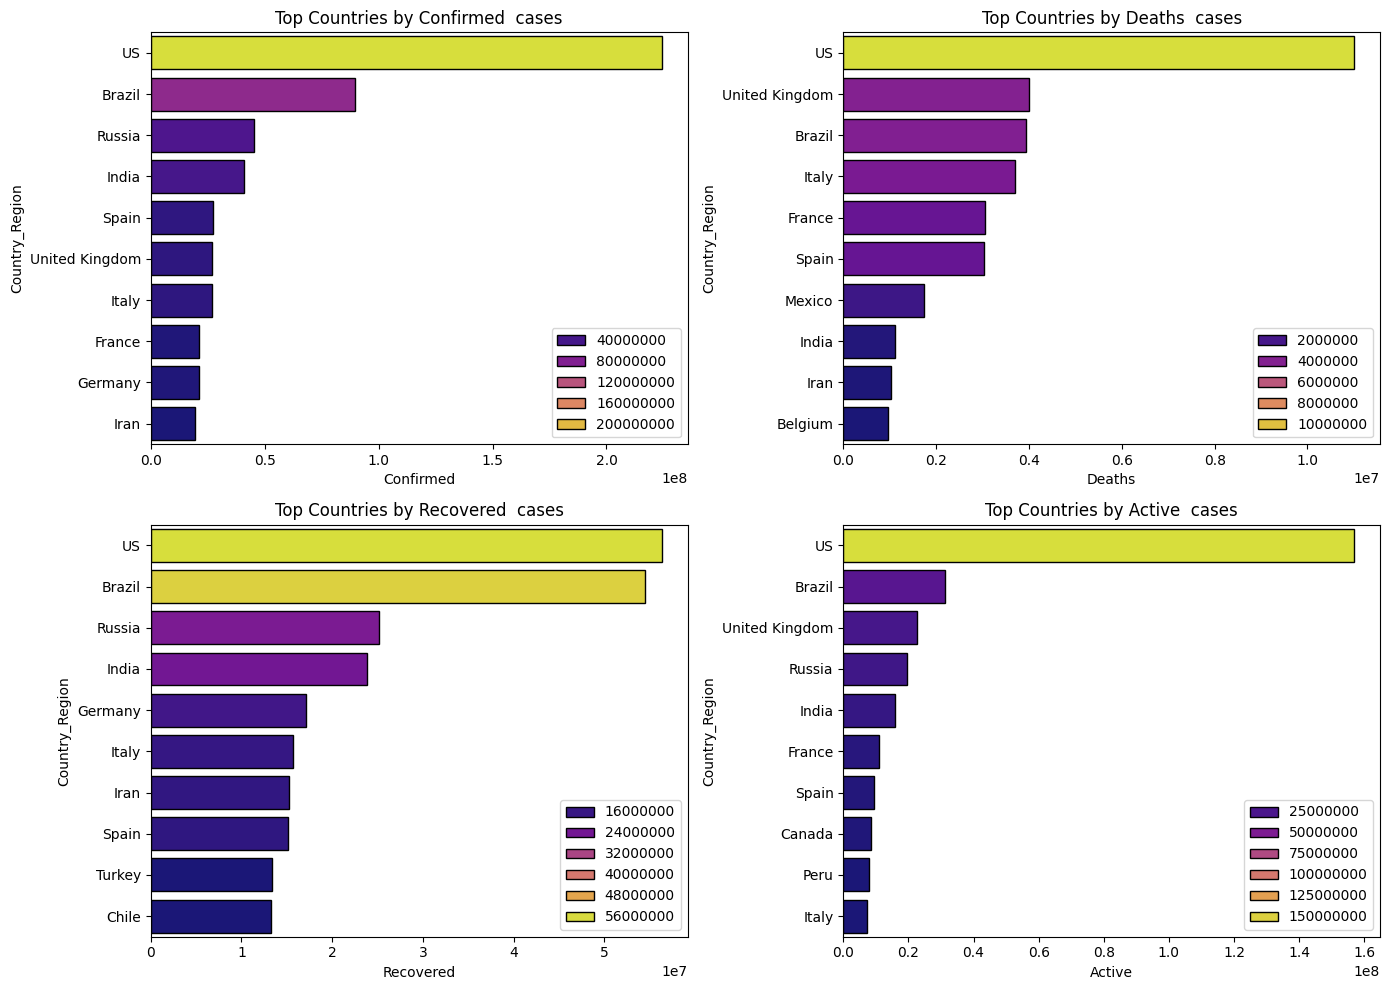

In [ ]:
# Top 10 countries visualization
fig, axes = plt.subplots(2,2, figsize=(14,10))
for ax, i in zip(axes.flat,countries.columns):
    top_data = countries[i].nlargest(10).reset_index()
    sns.barplot(data=top_data, x=i, y='Country_Region', hue=i, palette='plasma', edgecolor='black', ax=ax)
    ax.set_title(f"Top Countries by {i}  cases")
    ax.legend()
plt.tight_layout()
plt.show()


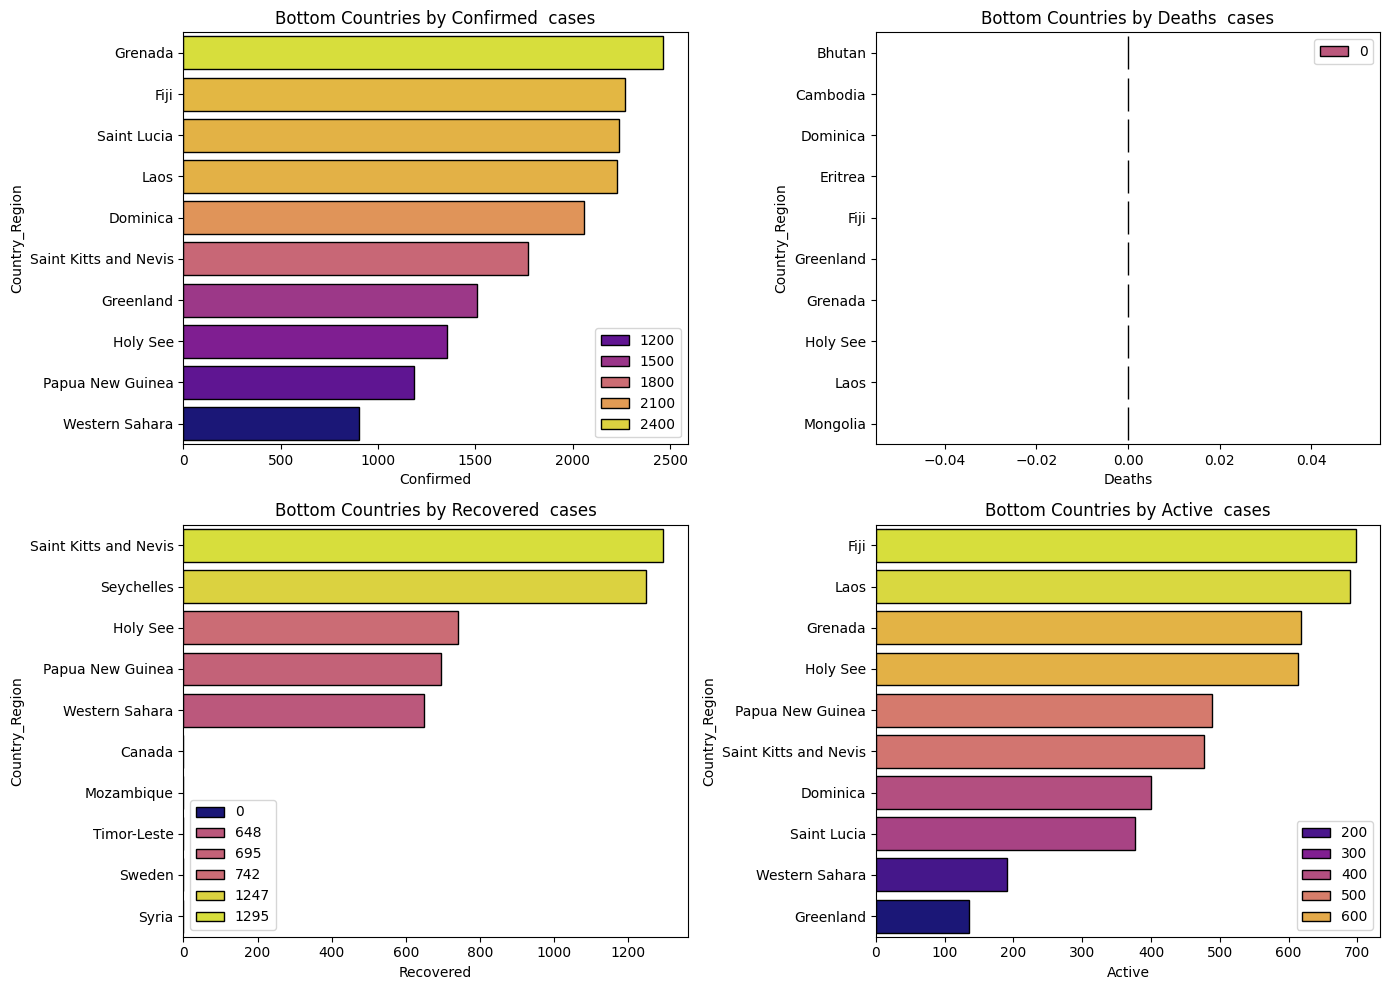

In [ ]:
#bottom ten countries visualization
fig, axes = plt.subplots(2,2, figsize=(14,10))
for ax, i in zip(axes.flat,countries.columns):
    bottom_data = countries[i].nsmallest(10).sort_values(ascending=False).reset_index()
    sns.barplot(data=bottom_data, x=i, y='Country_Region', hue=i, palette='plasma', edgecolor='black', ax=ax, order=bottom_data['Country_Region'])
    ax.set_title(f"Bottom Countries by {i}  cases")
    ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
# PART 2: Global Trend Analysis

# Aggregate global
agg_cols = [c for c in ["Confirmed", "Deaths", "Recovered", "Active"] if c in df.columns]
global_ts = df.groupby("Date")[agg_cols].sum().sort_index().reset_index()

# Global trends
fig1 = px.line(global_ts,x="Date",y="Confirmed",title="Global Confirmed Cases Over Time")
fig1.show()

fig2 = px.line(global_ts,x="Date",y="Deaths",title="Global Deaths Over Time")
fig2.show()

fig3 = px.line(global_ts,x="Date",y="Recovered",title="Global Recovered Cases Over Time")
fig3.show()

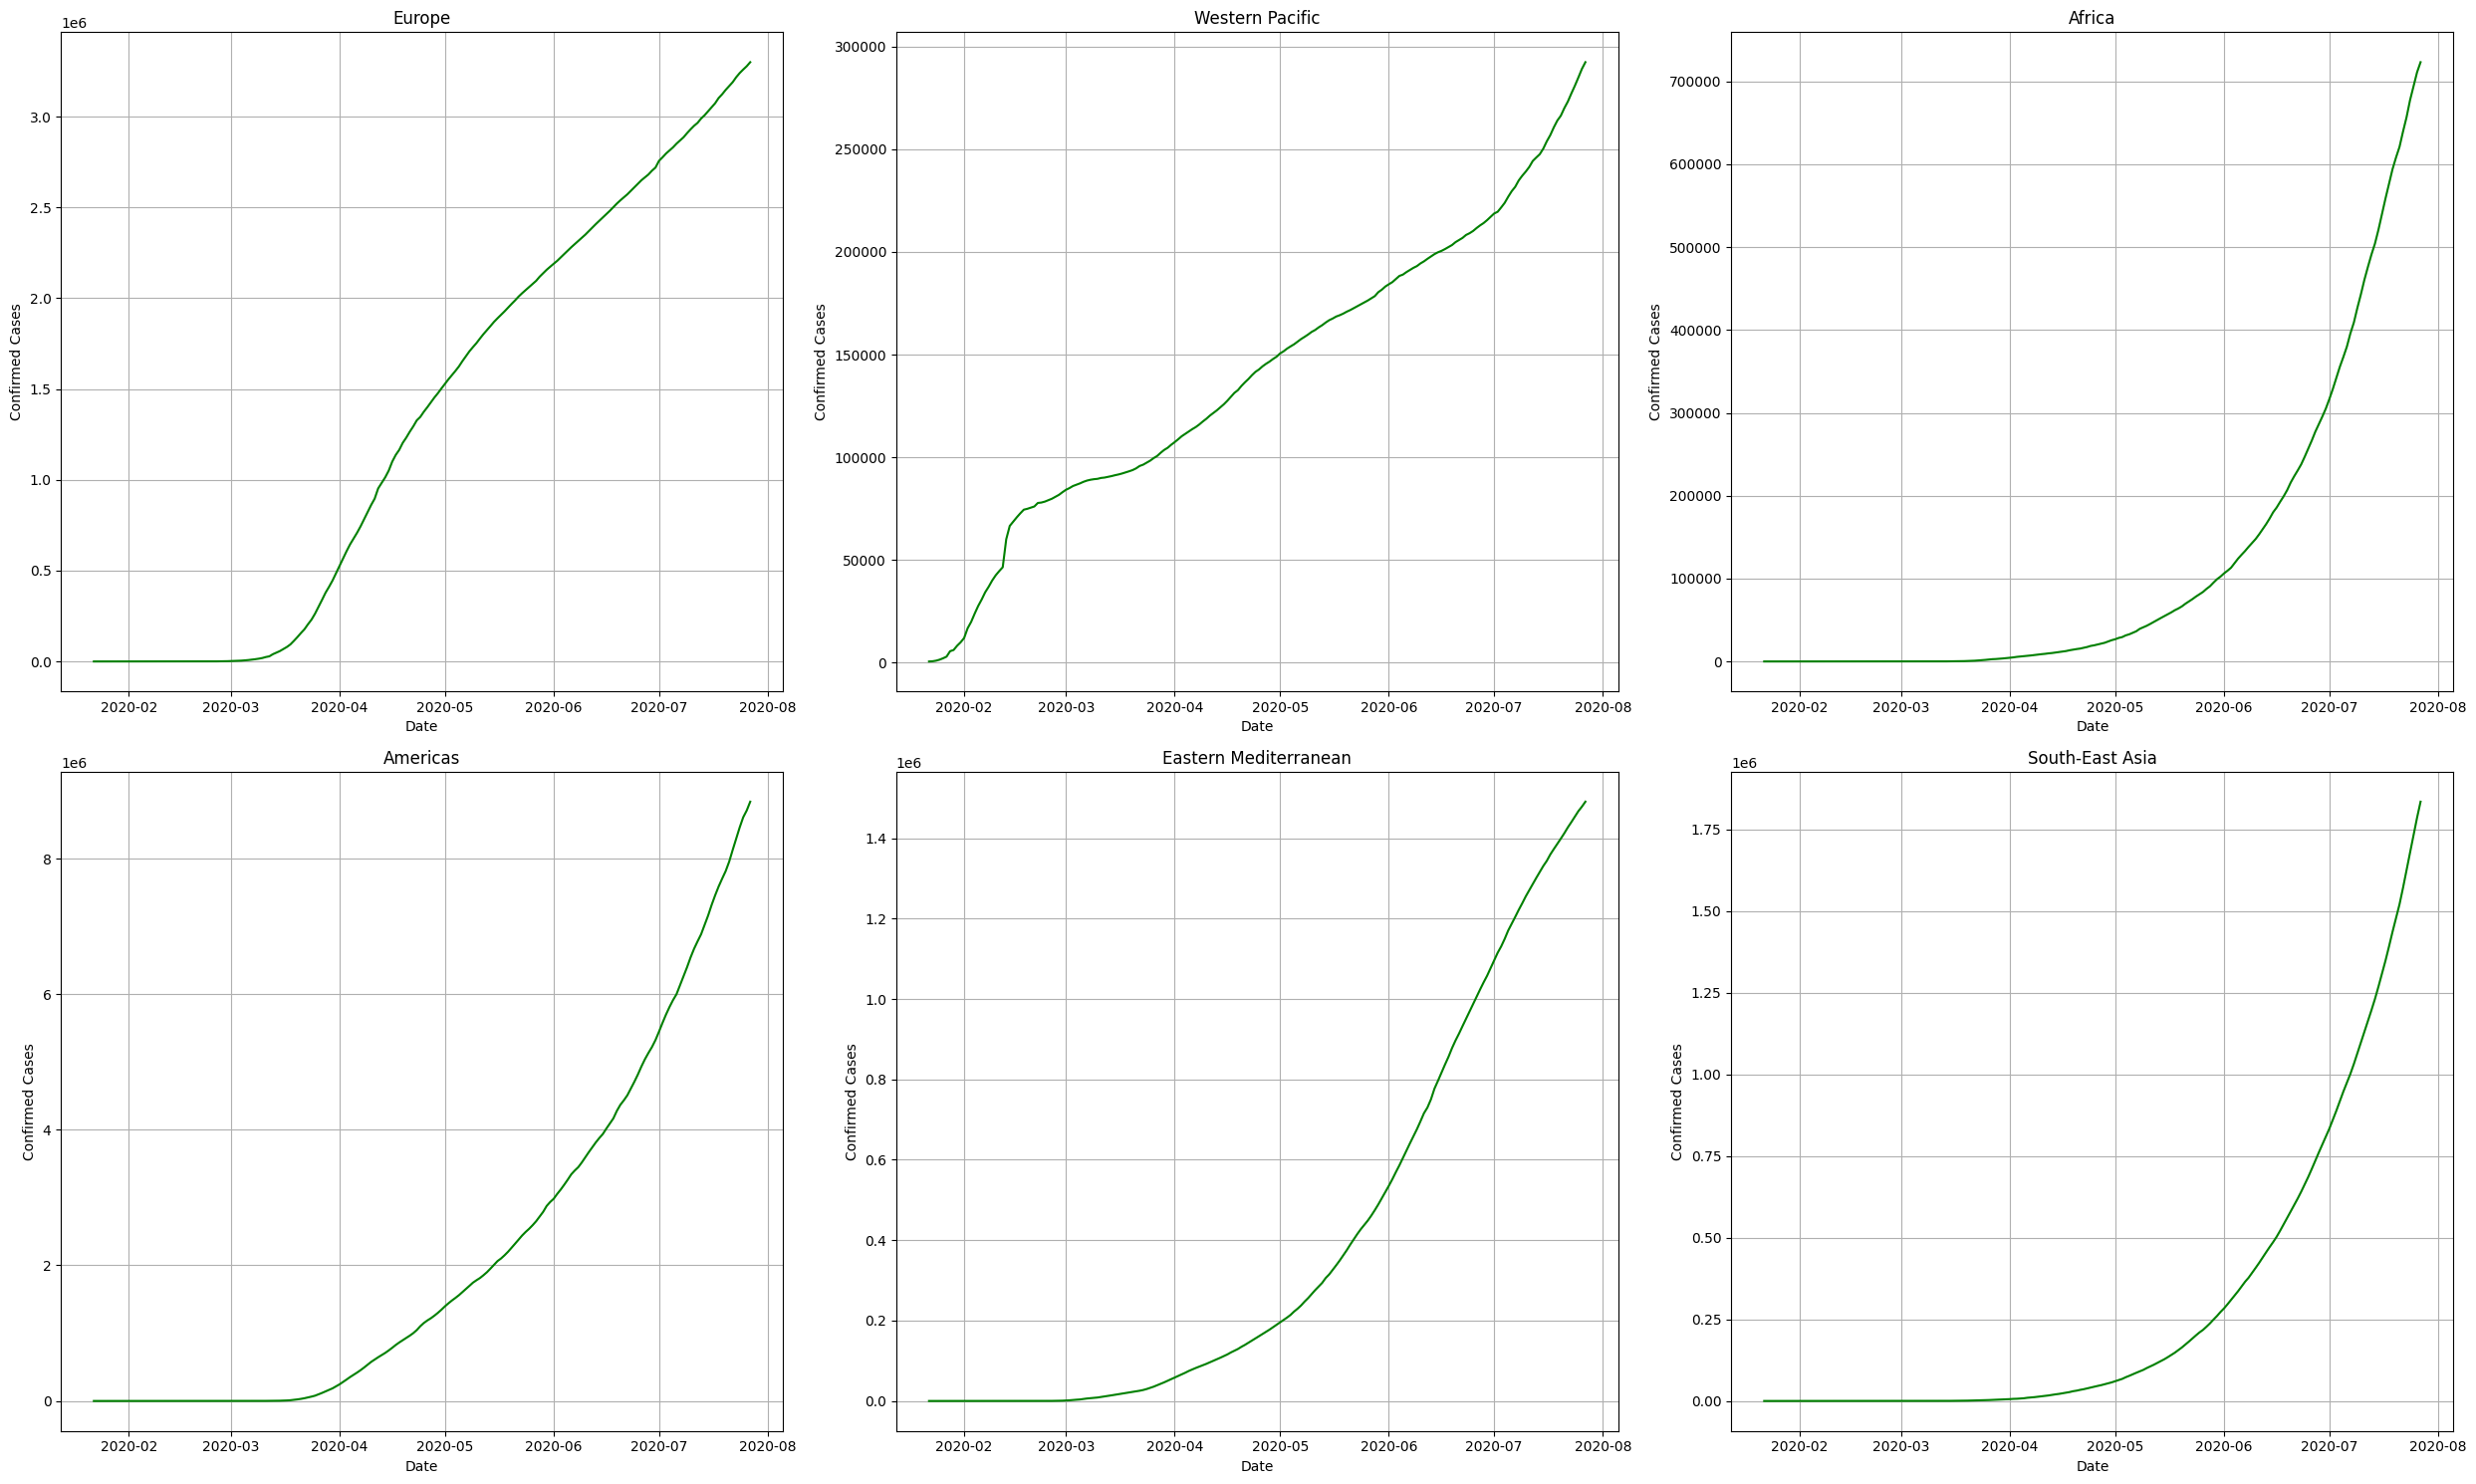

In [ ]:
#WHO regions
whos= df['WHO_Region'].value_counts().index
fig, axes = plt.subplots(2,3, figsize=(25,15))
for ax ,i in zip(axes.flat, whos ):
    data = df[df['WHO_Region']==i].groupby('Date')['Confirmed'].sum()
    sns.lineplot(x=data.index, y=data.values, ax=ax, color='green')
    ax.grid(True)
    ax.set_title(i)
    ax.set_ylabel("Confirmed Cases")

plt.tight_layout()
plt.show()

In [ ]:
#Heatmap according to rise of confirmed cases over the months
df['Month'] = df['Date'].dt.month
confirmed_who_month= df.groupby(['Month','WHO_Region'])['Confirmed'].sum().reset_index()
confirmed_who_month = confirmed_who_month.pivot(index='WHO_Region',columns='Month',values='Confirmed')
confirmed_who_month = confirmed_who_month/1000000

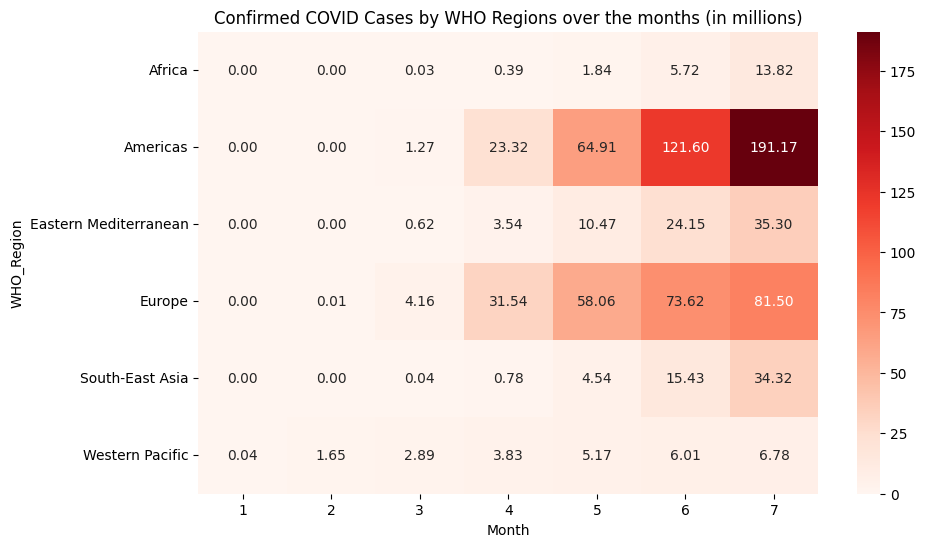

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(confirmed_who_month, annot=True,fmt=".2f", cmap='Reds')
plt.title("Confirmed COVID Cases by WHO Regions over the months (in millions)")
plt.show()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2yx3ao0n/ex7ysjta.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2yx3ao0n/mc3xodct.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3530', 'data', 'file=/tmp/tmp2yx3ao0n/ex7ysjta.json', 'init=/tmp/tmp2yx3ao0n/mc3xodct.json', 'output', 'file=/tmp/tmp2yx3ao0n/prophet_modeli_ypc4s_/prophet_model-20250829020247.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:02:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:02:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


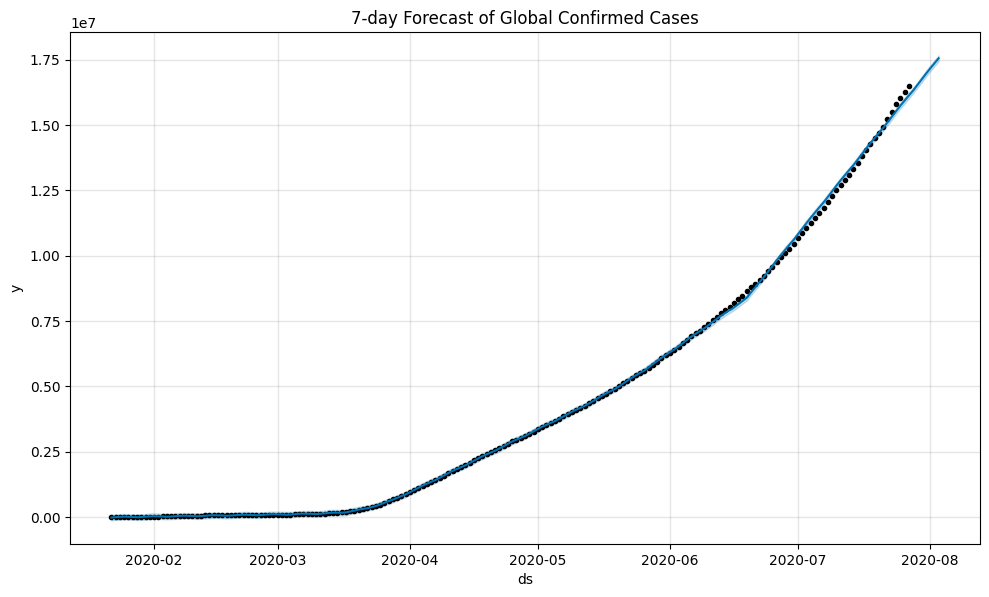

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Forcasting
# Prepare data
df_prophet = global_ts[["Date","Confirmed"]].rename(columns={"Date":"ds","Confirmed":"y"})

# Build & fit model
model = Prophet()
model.fit(df_prophet)

# Make 7-day forecast
future = model.make_future_dataframe(periods=7)
forecast = model.predict(future)

# Prophet default plot
fig6 = model.plot(forecast)
plt.title("7-day Forecast of Global Confirmed Cases")
plt.show()

# Interactive forecast
fig7 = px.line(forecast, x="ds", y="yhat", title="Prophet Forecast: Global Confirmed Cases")
fig7.add_scatter(x=df_prophet["ds"], y=df_prophet["y"], mode="lines", name="Actual")
fig7.show()

# Save forecast results
forecast[["ds","yhat","yhat_lower","yhat_upper"]].to_csv("forecast_prophet.csv", index=False)
files.download("forecast_prophet.csv")

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2yx3ao0n/lp8hdbyt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2yx3ao0n/lm_6bhvz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47391', 'data', 'file=/tmp/tmp2yx3ao0n/lp8hdbyt.json', 'init=/tmp/tmp2yx3ao0n/lm_6bhvz.json', 'output', 'file=/tmp/tmp2yx3ao0n/prophet_model3ay_7js1/prophet_model-20250829020838.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:08:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:08:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonalit

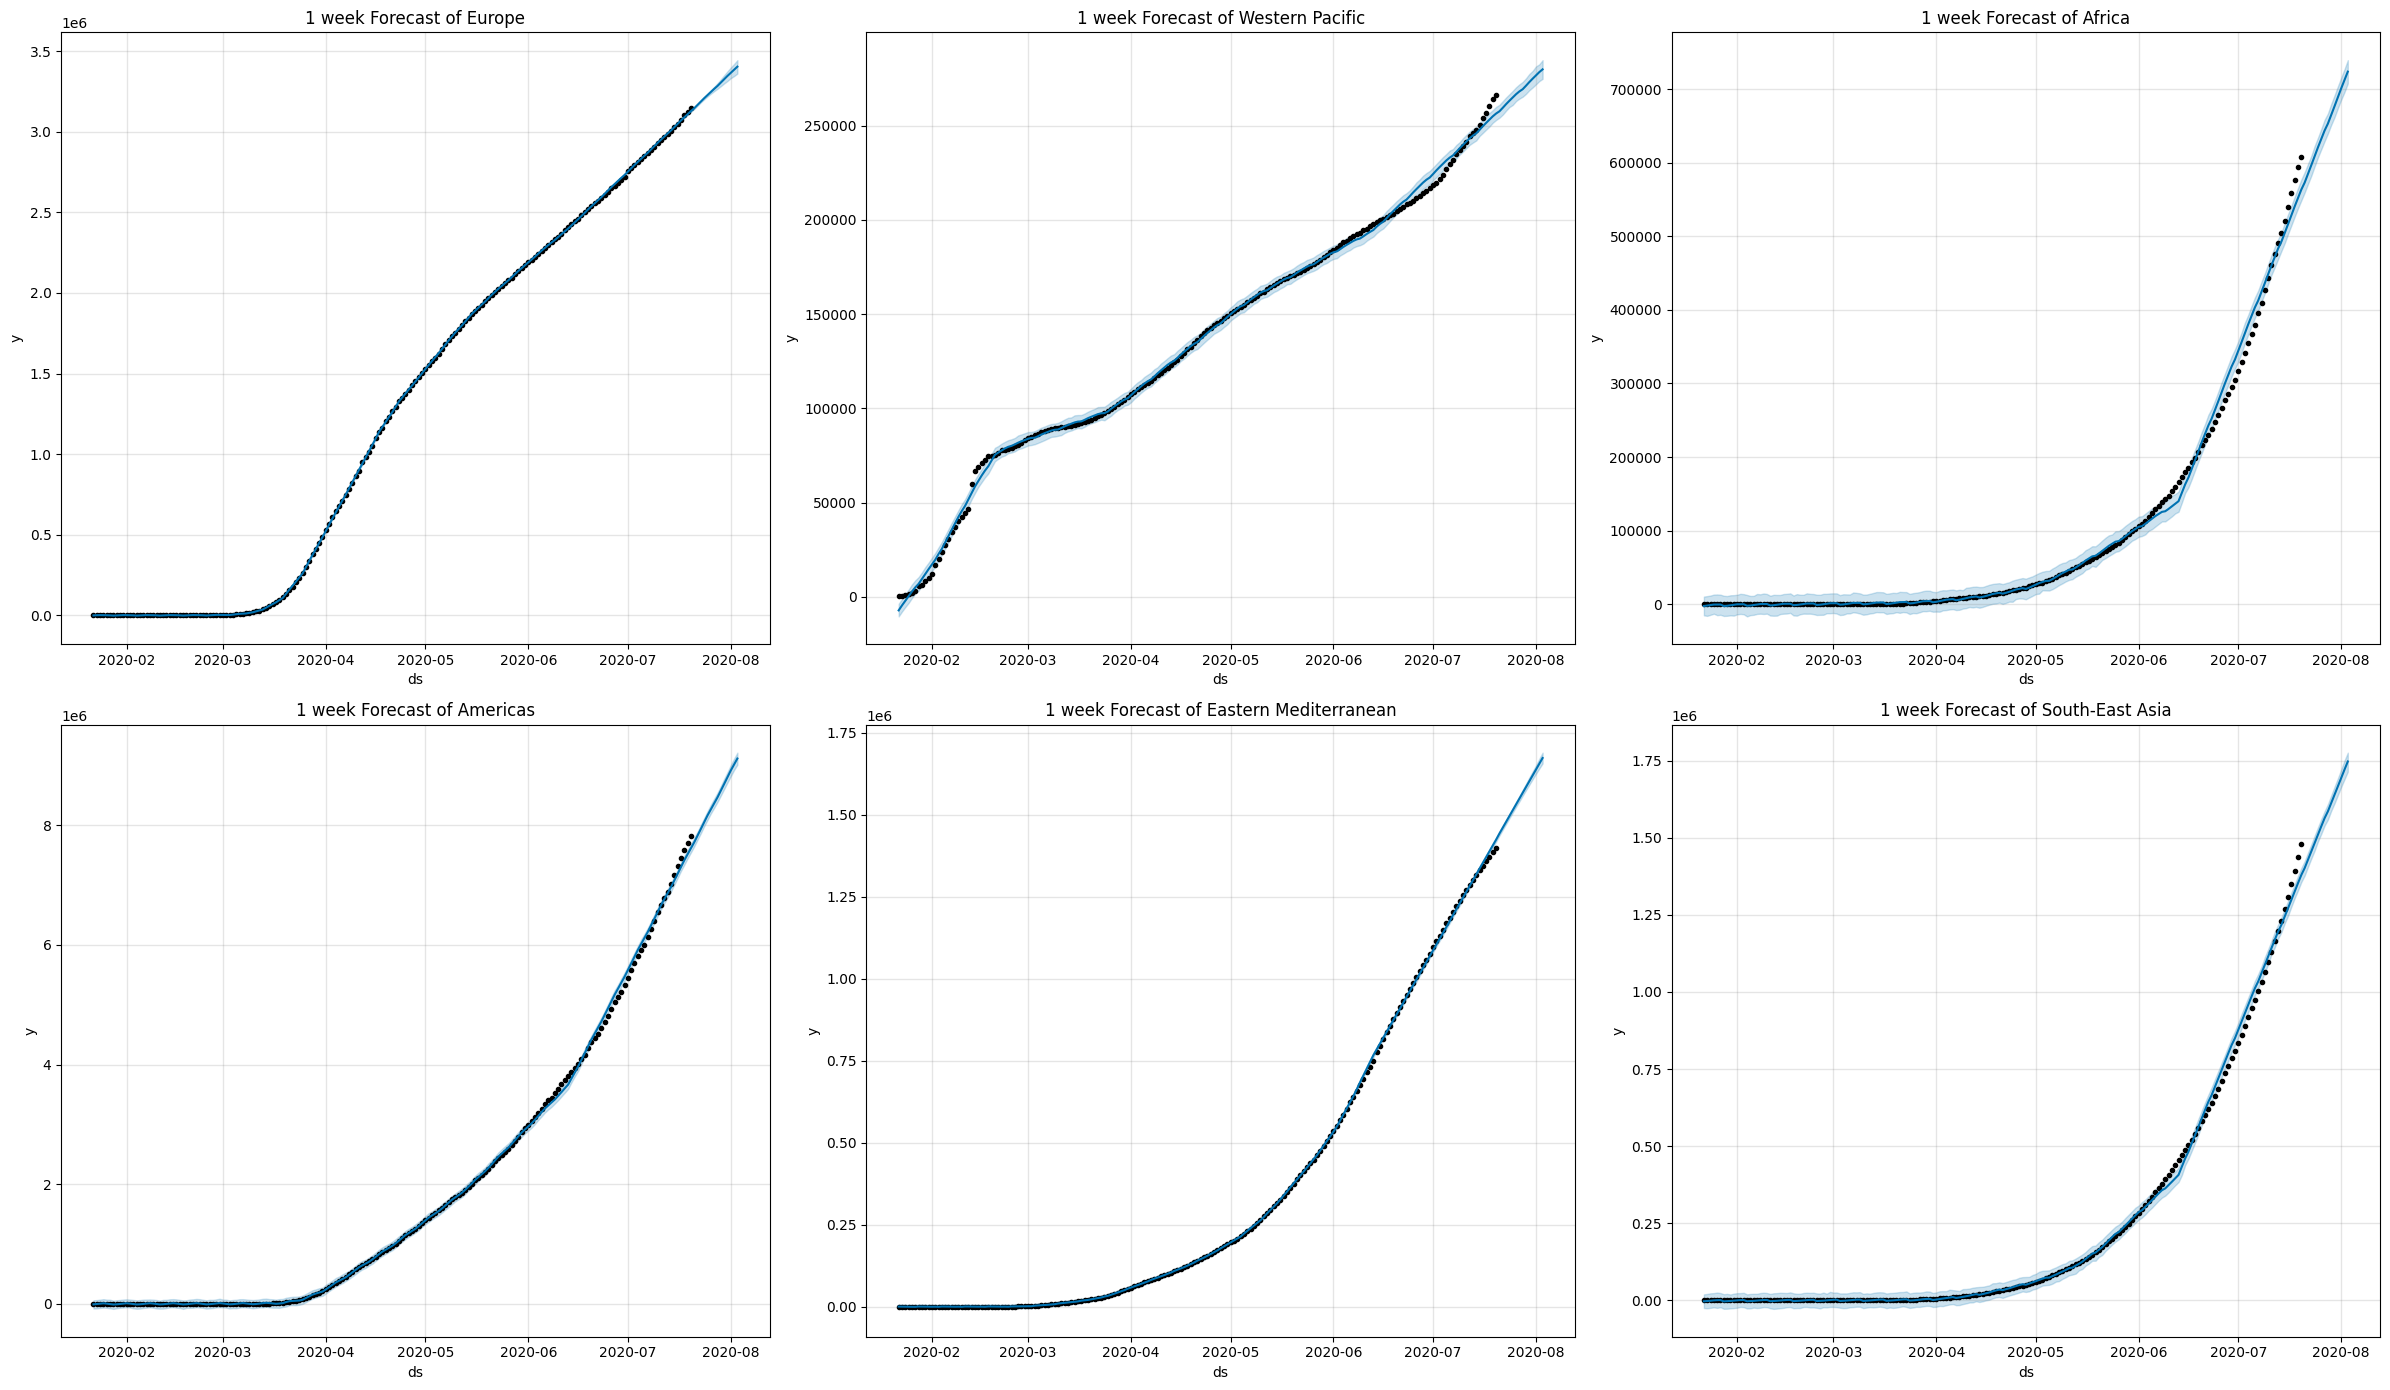

In [ ]:
from sklearn.metrics import root_mean_squared_error

fig, axes = plt.subplots(2, 3, figsize=(24, 14))
perf = []
for ax, i in zip(axes.flat, whos):
    who = df[df['WHO_Region'] == i][['Date','Confirmed']].copy()
    who.rename(columns={'Date': 'ds','Confirmed':'y'}, inplace=True)
    who = who.groupby('ds')['y'].sum().reset_index()
    train, test = who[:-7], who[-7:]

    model = Prophet()
    model.fit(train)
    future = model.make_future_dataframe(periods=14, freq='D')
    forecast = model.predict(future)
    model.plot(forecast, ax=ax)
    ax.grid(True)
    ax.set_title(f"1 week Forecast of {i}")

    pred_forecast = forecast[forecast['ds'].isin(test['ds'])]
    avg_cases = test['y'].mean()
    rmse_pct = (root_mean_squared_error(test['y'], pred_forecast['yhat']) / avg_cases) * 100
    perf.append(rmse_pct)

plt.tight_layout()
fig.savefig("prophet_whos_forecasts.png",dpi=300)
plt.show()

# Save performance metrics
perf_df = pd.DataFrame({"region": whos, "rmse_pct": perf})
perf_df.to_csv("forecast_performance.csv", index=False)


In [ ]:
pd.DataFrame({"WHO_Region":whos,"error ±%":perf})

,WHO_Region,error ±%
0,Europe,0.874320
1,Western Pacific,6.587765
2,Africa,9.947416
3,Americas,4.619222
4,Eastern Mediterranean,3.063102
5,South-East Asia,12.098304


email:akashbhavanisankar@gmail.com